<a href="https://colab.research.google.com/github/mojtabaSefidi/Dataminig-small-projects/blob/main/Driver_Behaviour_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [485]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
sn.set()

In [ ]:
!gdown --id 1SnKjUF251FLwoZ0AejsGOpIdKd43kO91
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d veeralakrishna/aggressive-driving-data
! unzip aggressive-driving-data.zip

In [449]:
data_part1 = pd.read_csv('Train_Data/Train.csv')
data_part2 = pd.read_csv('Train_Data/Train_Vehicletravellingdata.csv').drop_duplicates(subset=['ID'], keep='last').drop(['ID'],axis=1).reset_index()
data_part3 = pd.read_csv('Train_Data/Train_WeatherData.csv').drop_duplicates(subset=['ID'], keep='last').drop(['ID','V1'],axis=1).reset_index()
dataset = pd.concat([data_part1, data_part2, data_part3],axis=1)
dataset = dataset[['ID','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','DrivingStyle']]
dataset.rename(columns={'V1':'date','V2':'vehicle_length','V3':'road_lane','V4':'speed','V5':'vehicle_weight','V6':'num_axles','V7':'Id_preceding_car',
                      'V8':'speed_preceding','V9':'weight_preceding','V10':'length_preceding','V11':'time_gap','V12':'temperature','V13':'weather',
                      'V14':'intensity','V15':'humidity','V16':'wind_direction','V17':'wind_speed','V18':'road_condition','V19':'lighting_condition'},
               inplace=True)
dataset.head(2).T

,0,1
ID,DR_24526,DR_30052
date,2012-03-21 09:24:51,2012-03-21 09:40:25
vehicle_length,1265,1680
road_lane,1,2
speed,82,79
vehicle_weight,10243,30871
num_axles,2,6
Id_preceding_car,57246,57259
speed_preceding,79,78
weight_preceding,26187,1682


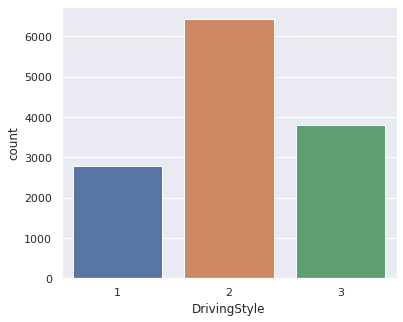

In [455]:
plt.figure(figsize=(6,5))
sn.countplot(x = dataset['DrivingStyle'])

In [357]:
Alldata = pd.read_csv('Train_Data/Train_Vehicletravellingdata.csv')
Alldata.rename(columns={'V1':'date','V3':'road_lane','V4':'speed','V7':'Id_preceding_car','V8':'speed_preceding','V9':'weight_preceding',
                     'V10':'length_preceding','V11':'time_gap','V18':'road_condition','V19':'lighting_condition'},
               inplace=True)
Alldata.head()

,ID,date,road_lane,speed,Id_preceding_car,speed_preceding,weight_preceding,length_preceding,time_gap,road_condition
0,DR_24526,2012-03-21 09:14:55,1,81,57227,87,16986,941,94.0,Dry
1,DR_24526,2012-03-21 09:15:07,1,88,57229,81,1708,551,11.0,Dry
2,DR_24526,2012-03-21 09:15:12,1,88,57230,88,22892,1698,4.0,Dry
3,DR_24526,2012-03-21 09:15:48,2,84,57228,89,1945,544,127.0,Dry
4,DR_24526,2012-03-21 09:15:54,1,89,57231,88,13787,1893,42.0,Dry


Text(0.5, 1.0, 'Id = DR_22231')

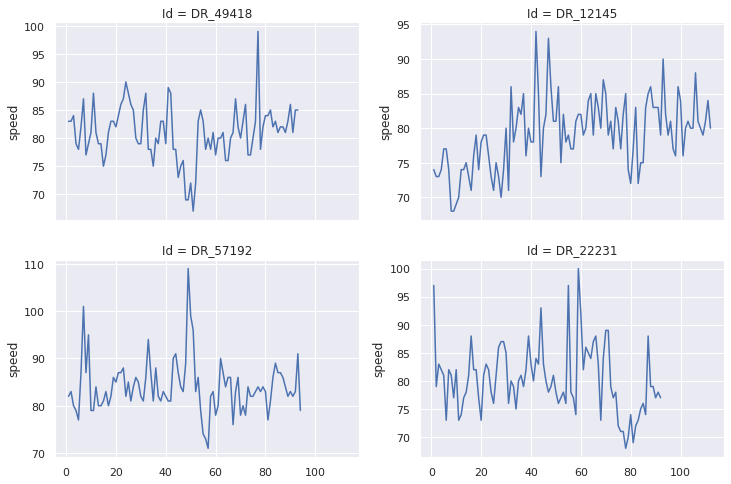

In [484]:
f, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
epoch1 = list(range(1,Alldata['ID'].value_counts()['DR_49418'] + 1))
epoch2 = list(range(1,Alldata['ID'].value_counts()['DR_12145'] + 1))
epoch3 = list(range(1,Alldata['ID'].value_counts()['DR_57192'] + 1))
epoch4 = list(range(1,Alldata['ID'].value_counts()['DR_22231'] + 1))
sn.lineplot(x=epoch1, y = Alldata[Alldata['ID']=='DR_49418']['speed'],ax=axes[0, 0])
sn.lineplot(x=epoch2, y = Alldata[Alldata['ID']=='DR_12145']['speed'],ax=axes[0, 1])
sn.lineplot(x=epoch3, y = Alldata[Alldata['ID']=='DR_57192']['speed'],ax=axes[1, 0])
sn.lineplot(x=epoch4, y = Alldata[Alldata['ID']=='DR_22231']['speed'],ax=axes[1, 1])
axes[0, 0].set_title("Id = DR_49418")
axes[0, 1].set_title("Id = DR_12145")
axes[1, 0].set_title("Id = DR_57192")
axes[1, 1].set_title("Id = DR_22231")

In [358]:
Alldata.isnull().sum()

ID                     0
date                   0
road_lane              0
speed                  0
Id_preceding_car       0
speed_preceding        0
weight_preceding       0
length_preceding       0
time_gap            2455
road_condition         0
dtype: int64

In [359]:
Alldata['time_gap'].fillna(round(Alldata['time_gap'].mean()) , inplace=True)
Alldata.isnull().sum()

ID                  0
date                0
road_lane           0
speed               0
Id_preceding_car    0
speed_preceding     0
weight_preceding    0
length_preceding    0
time_gap            0
road_condition      0
dtype: int64

In [ ]:
learning_data = Alldata[['ID','speed','road_lane']]
window_size = int(learning_data['ID'].value_counts().mean())
window = window_size * (learning_data.shape[1]-1)
new_dataset = np.empty((0, window+1), float)


In [361]:
(learning_data['ID'].value_counts()>learning_data['ID'].value_counts().mean()).sum()

4917

In [362]:
id_list = learning_data['ID'].unique()
for id in id_list:
  temp_data = learning_data[learning_data['ID']==id].drop('ID',axis=1).to_numpy()
  cut = temp_data.shape[0] % window_size
  temp_data = temp_data[:-cut,:]
  temp_data = temp_data.ravel().reshape(temp_data.size//window,window)
  label = np.ones(temp_data.size//window)*list(data_part1[data_part1['ID']==id]['DrivingStyle'])[0]
  new_dataset = np.concatenate((new_dataset,np.c_[temp_data,label]),axis=0)

new_dataset

array([[81.,  1., 88., ..., 85.,  2.,  2.],
       [87.,  1., 98., ..., 96.,  2.,  2.],
       [83.,  2., 82., ..., 89.,  2.,  2.],
       ...,
       [89.,  2., 90., ..., 87.,  2.,  3.],
       [90.,  2., 79., ..., 97.,  2.,  1.],
       [71.,  1., 78., ..., 87.,  1.,  2.]])

In [377]:
new_dataset_df = pd.DataFrame(new_dataset,columns = None)
new_dataset_df.columns = [*new_dataset_df.columns[:-1], 'DrivingStyle']
new_dataset_df['DrivingStyle'].value_counts()

2.0    3805
3.0    2265
1.0     884
Name: DrivingStyle, dtype: int64

In [378]:
df = new_dataset_df[new_dataset_df['DrivingStyle']==2.0]
new_dataset_df = new_dataset_df.append([df]*1,ignore_index=True)
df = new_dataset_df[new_dataset_df['DrivingStyle']==3.0]
new_dataset_df = new_dataset_df.append([df]*2,ignore_index=True)
df = new_dataset_df[new_dataset_df['DrivingStyle']==1.0]
new_dataset_df = new_dataset_df.append([df]*9,ignore_index=True)

new_dataset_df['DrivingStyle'].value_counts()

1.0    8840
2.0    7610
3.0    6795
Name: DrivingStyle, dtype: int64

In [379]:
dataset = new_dataset_df.sample(frac=1).reset_index(drop=True).to_numpy()

In [380]:
features = dataset[:,:-1]
labels = dataset[:,-1]
print(dataset.shape)
print(features.shape)
print(labels.shape)

(23245, 25)
(23245, 24)
(23245,)


In [381]:
from sklearn import preprocessing
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)


In [382]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, shuffle=True)
X_test.shape

(7671, 24)

In [406]:
rfc = RandomForestClassifier(random_state=1)
rfc.fit(X_train, y_train)

print("Accuracy on Train: " + str(rfc.score(X_train, y_train).round(3)))
print("Accuracy on Test: " + str(rfc.score(X_test, y_test).round(3)))

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy on Train: 1.0
Accuracy on Test: 0.955
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      2886
         2.0       0.92      0.94      0.93      2541
         3.0       0.93      0.91      0.92      2244

    accuracy                           0.95      7671
   macro avg       0.95      0.95      0.95      7671
weighted avg       0.95      0.95      0.95      7671

[[2886    0    0]
 [   4 2387  150]
 [   0  195 2049]]


In [407]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
param_dict = {
    'n_estimators' : range(1,1001,100),
    'min_samples_split' : [1, 2, 3],
    'min_samples_leaf' : [1, 2, 4],
}

grid = GridSearchCV(RandomForestClassifier(),param_dict,cv=5,verbose=1)
grid.fit(X_train, y_train)
optimal_params = grid.best_params_


In [404]:
print('optimal Parameters :',optimal_params)

optimal Parameters : {'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 90}


In [408]:
rfc = RandomForestClassifier(random_state=1)
rfc.set_params(**optimal_params)
rfc.fit(X_train, y_train)
print("Accuracy on Train: " + str(rfc.score(X_train, y_train).round(3)))
print("Accuracy on Test: " + str(rfc.score(X_test, y_test).round(3)))


y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy on Train: 1.0
Accuracy on Test: 0.957
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      2886
         2.0       0.93      0.94      0.94      2541
         3.0       0.93      0.92      0.93      2244

    accuracy                           0.96      7671
   macro avg       0.95      0.95      0.95      7671
weighted avg       0.96      0.96      0.96      7671

[[2886    0    0]
 [   4 2389  148]
 [   0  180 2064]]


In [409]:
dtc = DecisionTreeClassifier(random_state=1)
dtc = dtc.fit(X_train, y_train)
print("Accuracy on Train: " + str(dtc.score(X_train, y_train).round(3)))
print("Accuracy on Test: " + str(dtc.score(X_test, y_test).round(3)))


y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy on Train: 1.0
Accuracy on Test: 0.928
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.97      2886
         2.0       0.93      0.85      0.89      2541
         3.0       0.89      0.92      0.91      2244

    accuracy                           0.93      7671
   macro avg       0.93      0.92      0.92      7671
weighted avg       0.93      0.93      0.93      7671

[[2886    0    0]
 [ 126 2171  244]
 [  30  153 2061]]


In [410]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [ ]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 22)]
max_depth.append(None)
param_dict = {
    'criterion': ['gini','entropy'],
    'max_depth' : max_depth ,
    'min_samples_split' : [1,2,3],
    'min_samples_leaf' : [1,2,4],
}

grid = GridSearchCV(DecisionTreeClassifier(),param_dict,cv=5,verbose=1)
grid.fit(X_train, y_train)
optimal_params = grid.best_params_
print('optimal Parameters :',optimal_params)

In [ ]:
optimal_params

{'criterion': 'gini',
 'max_depth': 90,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
dtc = DecisionTreeClassifier(random_state=1)
dtc.set_params(**optimal_params)
dtc = dtc.fit(X_train, y_train)
print("Accuracy on Train: " + str(dtc.score(X_train, y_train).round(3)))
print("Accuracy on Test: " + str(dtc.score(X_test, y_test).round(3)))


y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy on Train: 1.0
Accuracy on Test: 0.93
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.97      2962
         2.0       0.95      0.84      0.90      2489
         3.0       0.88      0.93      0.91      2220

    accuracy                           0.93      7671
   macro avg       0.93      0.93      0.93      7671
weighted avg       0.93      0.93      0.93      7671

[[2962    0    0]
 [ 116 2099  274]
 [  48   99 2073]]


In [ ]:
svm=SVC()
svm.fit(X_train, y_train)
print("Accuracy on Train: " + str(svm.score(X_train, y_train).round(3)))
print("Accuracy on Test: " + str(svm.score(X_test, y_test).round(3)))
print()
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy on Train: 0.775
Accuracy on Test: 0.691

              precision    recall  f1-score   support

         1.0       0.75      0.87      0.80      2962
         2.0       0.65      0.57      0.60      2489
         3.0       0.64      0.60      0.62      2220

    accuracy                           0.69      7671
   macro avg       0.68      0.68      0.68      7671
weighted avg       0.68      0.69      0.69      7671

[[2564  216  182]
 [ 518 1409  562]
 [ 341  550 1329]]


In [ ]:
svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
param_dict = {
    'C' : [0.01,0.5,1,4],
    'kernel' : ['linear','rbf']
}

grid = GridSearchCV(SVC(),param_dict,cv=5,verbose=1)
grid.fit(X_train, y_train)
optimal_params = grid.best_params_
optimal_params

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'C': 4, 'kernel': 'rbf'}

In [ ]:
svm = SVC(random_state=1)
svm.set_params(**optimal_params)
svm.fit(X_train, y_train)
print("Accuracy on Train: " + str(svm.score(X_train, y_train).round(3)))
print("Accuracy on Test: " + str(svm.score(X_test, y_test).round(3)))


y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy on Train: 0.912
Accuracy on Test: 0.807
              precision    recall  f1-score   support

         1.0       0.86      0.96      0.91      2962
         2.0       0.78      0.68      0.73      2489
         3.0       0.74      0.74      0.74      2220

    accuracy                           0.81      7671
   macro avg       0.80      0.79      0.79      7671
weighted avg       0.80      0.81      0.80      7671

[[2855   49   58]
 [ 289 1695  505]
 [ 158  422 1640]]


In [ ]:
param_dict = {
    'C' : [4,8,16,32]
}

grid = GridSearchCV(SVC(),param_dict,cv=5,verbose=1)
grid.fit(X_train, y_train)
optimal_params = grid.best_params_
optimal_params

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'C': 32}

In [ ]:
svm = SVC(random_state=1)
svm.set_params(**optimal_params)
svm.fit(X_train, y_train)
print("Accuracy on Train: " + str(svm.score(X_train, y_train).round(3)))
print("Accuracy on Test: " + str(svm.score(X_test, y_test).round(3)))


y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy on Train: 0.992
Accuracy on Test: 0.912
              precision    recall  f1-score   support

         1.0       0.94      1.00      0.97      2962
         2.0       0.92      0.81      0.86      2489
         3.0       0.86      0.91      0.89      2220

    accuracy                           0.91      7671
   macro avg       0.91      0.91      0.91      7671
weighted avg       0.91      0.91      0.91      7671

[[2957    5    0]
 [ 148 2023  318]
 [  29  174 2017]]


In [ ]:
param_dict = {
    'C' : [512,1024,2048,4096]
}

grid = GridSearchCV(SVC(),param_dict,cv=5,verbose=1)
grid.fit(X_train, y_train)
optimal_params = grid.best_params_
optimal_params

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'C': 1024}

In [ ]:
svm = SVC(random_state=1)
svm.set_params(**optimal_params)
svm.fit(X_train, y_train)
print("Accuracy on Train: " + str(svm.score(X_train, y_train).round(3)))
print("Accuracy on Test: " + str(svm.score(X_test, y_test).round(3)))


y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy on Train: 1.0
Accuracy on Test: 0.925
              precision    recall  f1-score   support

         1.0       0.94      1.00      0.97      2962
         2.0       0.94      0.83      0.88      2489
         3.0       0.88      0.93      0.91      2220

    accuracy                           0.92      7671
   macro avg       0.92      0.92      0.92      7671
weighted avg       0.93      0.92      0.92      7671

[[2962    0    0]
 [ 150 2069  270]
 [  33  123 2064]]


In [487]:
conclusion = pd.DataFrame([['Random forest',0.95,0.95,0.95,0.95],
              ['Random forest after tuning',0.95,0.95,0.95,0.96],
              ['Decision tree',0.93,0.92,0.92,0.93],
              ['Decision tree after tuning',0.93,0.93,0.93,0.93],
              ['SVM',0.68,0.68,0.68,0.69],
              ['Decision tree after tuning(C=4)',0.80,0.79,0.79,0.81],
              ['Decision tree after tuning(C=1024)',0.92,0.92,0.92,0.92]],
              columns=["Algorithm","Precision","Recall","F1score",'Accuracy'])
conclusion = conclusion.set_index('Algorithm')
conclusion.style.background_gradient(cmap="Blues")


,Precision,Recall,F1score,Accuracy
Algorithm,,,,
Random forest,0.950000,0.950000,0.950000,0.950000
Random forest after tuning,0.950000,0.950000,0.950000,0.960000
Decision tree,0.930000,0.920000,0.920000,0.930000
Decision tree after tuning,0.930000,0.930000,0.930000,0.930000
SVM,0.680000,0.680000,0.680000,0.690000
Decision tree after tuning(C=4),0.800000,0.790000,0.790000,0.810000
Decision tree after tuning(C=1024),0.920000,0.920000,0.920000,0.920000
